In [1]:
%matplotlib inline
#%config InlineBackend.figure_format='retina'

import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import word_tokenize          
from nltk.stem.porter import PorterStemmer
import nltk
import networkx as nx
import seaborn as sns
#import community

# To make the figures look nice and large
#plt.rcParams['figure.figsize'] = (40.0, 30.0)
#plt.rcParams['image.interpolation'] = 'nearest'

# 1. Wordclouds
## Loading the data

In [2]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv")
emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


First we inspect what data we are given. For the wordcloud it would be wise to use only the "ExtractedBodyText" column.

In [3]:
emails.columns.values

array(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'], dtype=object)

## Removing emails without body text

In [4]:
emails.size #Size of the dataset before

174790

In [5]:
emails = emails[pd.notnull(emails['ExtractedBodyText'])]
emails.size #Size of the dataset after

148324

## Generating the wordcloud

Converting the ExtractedBodyText into strings we can use for the wordcloud. Note that we tell WordCloud to not remove any stopwords for this first graph.

In [6]:
text = emails.ExtractedBodyText.str.cat(sep='\n')

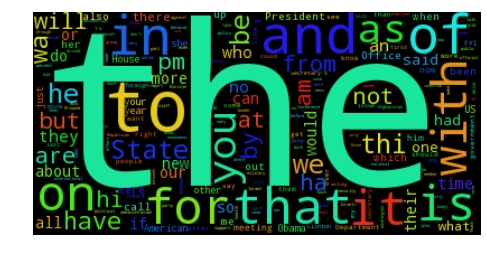

In [7]:
wordcloud = WordCloud(stopwords=['']).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Improving the wordcloud

To improve the wordcloud we will go through the process of removing stopwords. Then we will make sure to have only alphabetical characters and use stemming to convert words into their original base form.

In [8]:
stemmer = PorterStemmer()
sw = stopwords.words("english")

In [9]:
def tokenize(text):
    tokens = nltk.word_tokenize(text) # Tokenizing the text
    tokens = [i for i in tokens if i.isalpha()] #Keeping only strings with alphabetic characters
    tokens = [i for i in tokens if i.lower() not in sw] #Removing stopwords
    stems = stem_tokens(tokens, stemmer) #Stemming the words
    return stems  #returns a list

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed 

In [10]:
improvedText = str(tokenize(text)).replace("'", "") #Convert from list to string object without single quotes

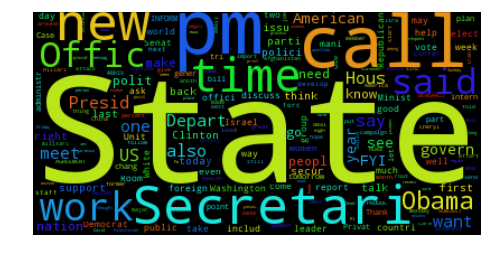

In [11]:
wc = WordCloud().generate(improvedText)
plt.imshow(wc)
plt.axis("off")
plt.show()

When comparing the two wordclouds, we see that they are very different. In the first cloud we have all the stopwords, which means the wordcloud does not show us any indication of some specific characteristics of Hillary Clinton emails.  In the second cloud some words are shortened to their stems such as 'Novemb' and 'relea'. The stopwords are removed, so we see a better representation of the most common words used in the emails.

# 2. Sentiment analysis
First, let's see which countries we can find in the emails corpus using the `lookup()` method of pycountry. It looks for any reference to a country, i.e. its full name, its official name or its two or three letters code. The search is **not** case sentitive. We tokenize each email and look if a token matches a country. There is a major problem with this approach, if a country name contains multiple words (e.g. Ivory Coast or Hong Kong), it won't be detected. However it allows us to identify another issue that we'll discuss below.

In [12]:
import pycountry

stopwords = nltk.corpus.stopwords.words('english')

countries = []

for text in emails.ExtractedBodyText.dropna():
    text = text.lower()
    
    tokens = nltk.word_tokenize(text)
    
    for token in tokens:
        if token not in stopwords:
            try:
                country = pycountry.countries.lookup(token)
                countries.append(country.name)
            except LookupError:
                pass

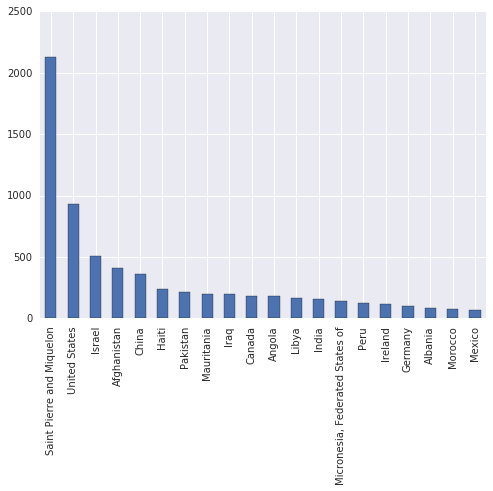

In [13]:
df_countries = pd.Series(countries)
df_countries.value_counts().sort_values(ascending=False).head(20).plot(kind='bar')

As seen on the previous plot, there are some countries that are over represented, especially given their small size. For instance St Pierre and Miquelon or Micronesia. This is because their 2 letter codes are PM and FM which stand for Prime Minister and Foreign Minister. Moreover PM is also used for time notation. Because of this, we chose not to use 2 and 3 letters codes. We could have used a white or blacklist but there is no way to be sure we don't miss or match too many countries.

Our final method to detect mentions is the following: for each email we loop over every country and check if there is a match with the content of the email. To do this we use a case insensitive regular expression to detect if the usual or official name of a country is present as a word in the document (can't be just a part of a word because of countries like Oman which would match the word 'woman'). We also created a python dictionary to override some of the names (only for the common names, not for the official ones) given by the pycountry library because they were overly complicated and did not match the name people usually use.

For each email we also analyze its content to get a score representing the sentiment associated with the text. We add this score in a dictionnary for each country mentioned in the text. At the end we average the score of each country. The first example uses the VADER sentiment analysis tools.

*Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.*

In [14]:
name_dict = {
    "Bolivia, Plurinational State of": "Bolivia",
    "Bosnia and Herzegovina": "Bosnia",
    "Bonaire, Sint Eustatius and Saba": "Caribbean Netherlands",
    "Brunei Darussalam": "Brunei",
    "Micronesia, Federated States of": "Micronesia",
    "Falkland Islands (Malvinas)": "Falkland Islands",
    "Micronesia, Federated States of": "Micronesia",
    "Iran, Islamic Republic of": "Iran",
    "Korea, Republic of": "South Korea",
    "Lao People's Democratic Republic": "Laos",
    "Saint Martin (French part)": "Saint Martin",
    "Moldova, Republic of": "Moldova",
    "Macedonia, Republic of": "Macedonia",
    "Korea, Democratic People's Republic of": "North Korea",
    "Palestine, State of": "Palestine",
    "Russian Federation": "Russia",
    "Saint Helena, Ascension and Tristan da Cunha": "Saint Helena",
    "Svalbard and Jan Mayen": "Svalbard",
    "Sint Maarten (Dutch part)": "Sint Maarten",
    "Syrian Arab Republic": "Syria",
    "Taiwan, Province of China": "Taiwan",
    "Tanzania, United Republic of": "Tanzania",
    "Holy See (Vatican City State)": "Vatican",
    "Venezuela, Bolivarian Republic of": "Venezuela",
    "United States Minor Outlying Islands": "US Virgin Islands"
}

In [15]:
import pycountry
import re
from collections import defaultdict

def sentiment_per_country(scoring_function):
    # scoring_function is a function taking text as input and returning a score between -1 and 1
    # -1 is negative, 1 is positive
    
    countries = defaultdict(list)
    
    for text in emails.ExtractedBodyText.dropna():
        polarity_score = scoring_function(text)

        for country in pycountry.countries:
            name = name_dict.get(country.name, country.name)
            try:
                regex = r'\b(?:{}|{})\b'.format(name, country.official_name)
            except AttributeError: # Not all countries have an official name field
                regex = r'\b{}\b'.format(name)
    
            if re.search(regex, text, re.IGNORECASE):
                countries[name].append(polarity_score)
    
    return countries

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()
countries = sentiment_per_country(lambda t: vader.polarity_scores(t)['compound'])

/home/marmotte/anaconda3/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Below is the plot of the average sentiment associated with each country mentionned in the emails. The score goes from -1 to 1, -1 being the most negative and 1 being the most positive.

In [17]:
def color_map(score, color_scheme):
    # score is expected to be between -1 and 1
    index = (score + 1) / 2 * (len(color_scheme) - 1) # map the score to a color
    return color_scheme[round(index)]

def plot_scores(countries):
    scores = pd.DataFrame.from_dict(countries, orient='index').mean(axis=1).sort_values()
    df_countries = pd.DataFrame({'score': scores})
    df_countries['color'] = df_countries.score.apply(lambda x: color_map(x, ['#d73027','#fc8d59','#fee08b','#d9ef8b','#91cf60','#1a9850']))

    df_countries.score.plot(figsize=(15, 50), kind='barh', grid=True, width=0.7, color=df_countries.color)

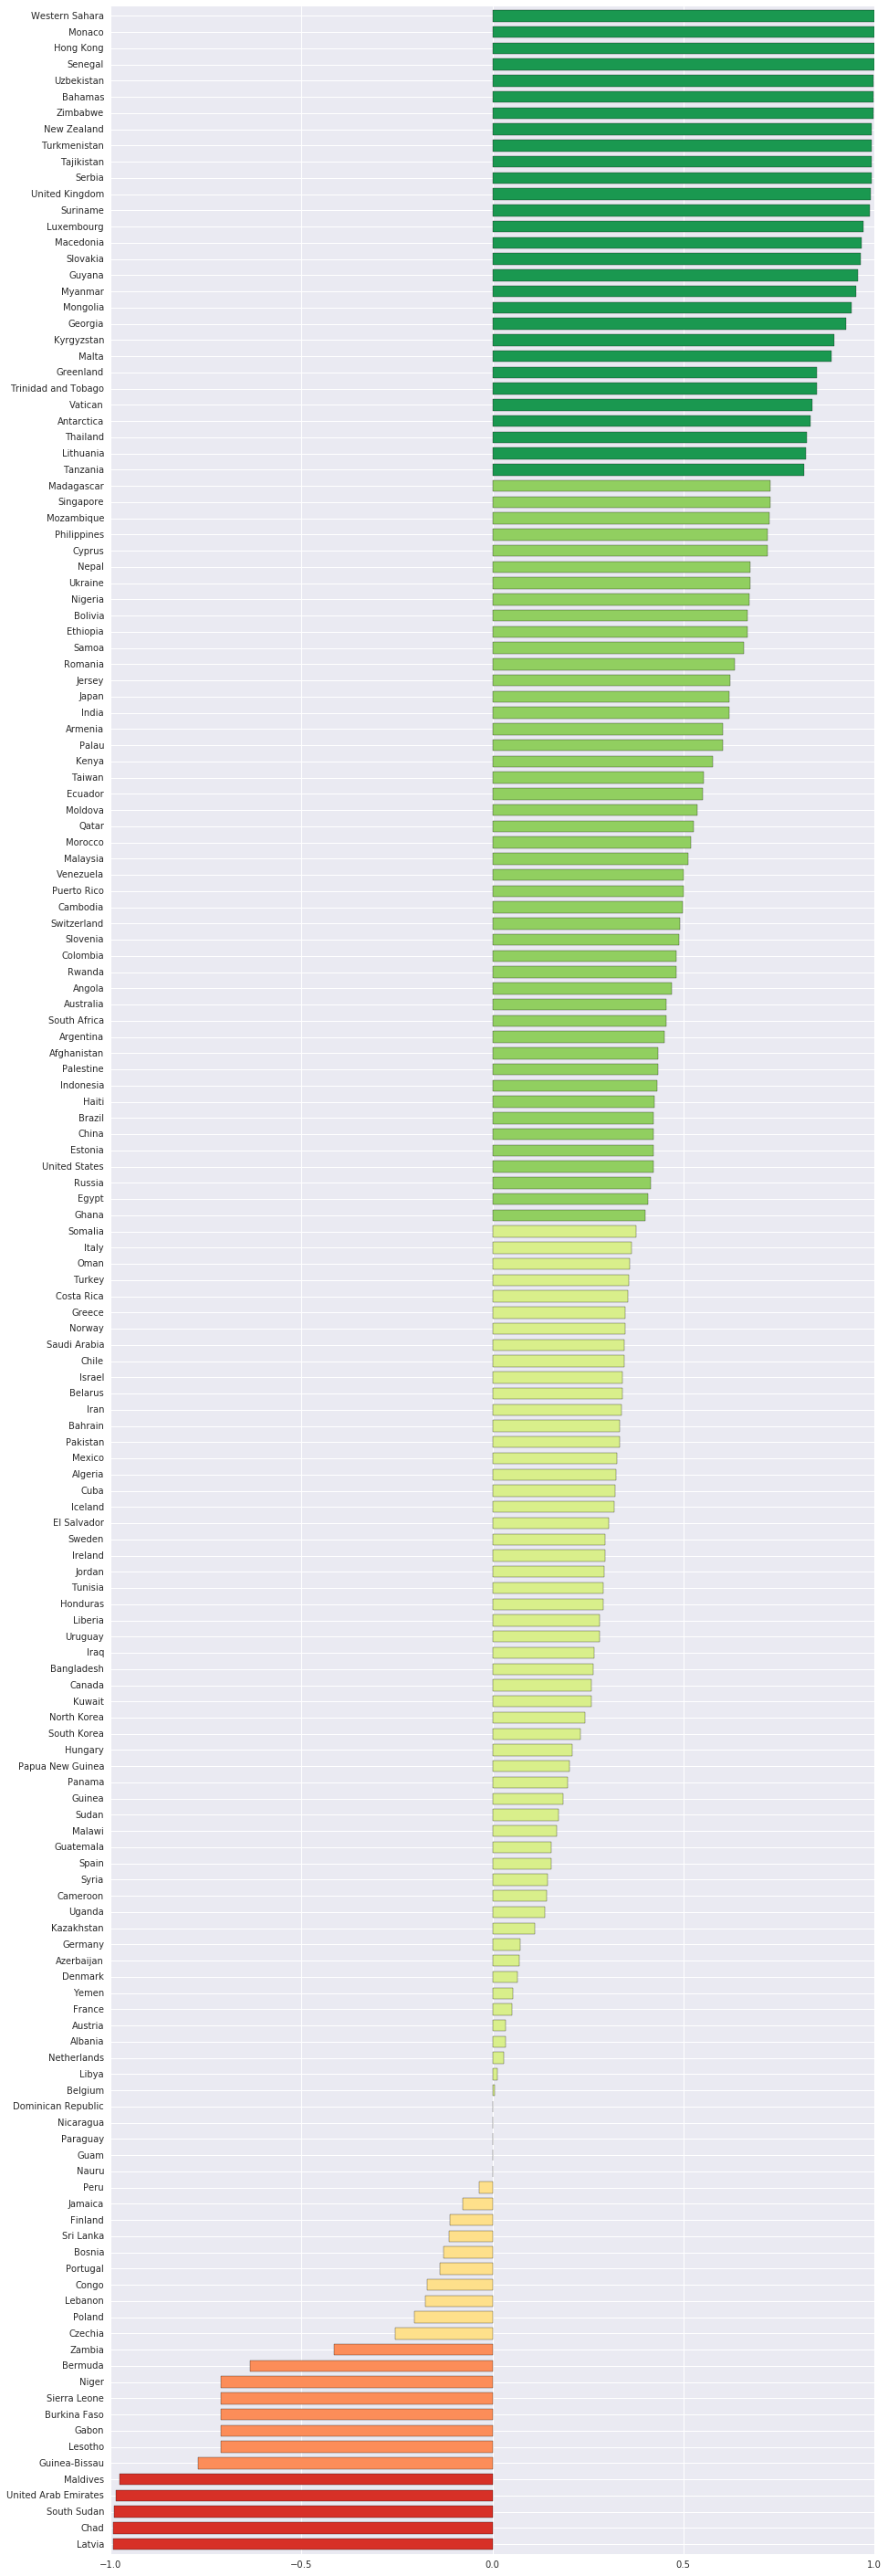

In [18]:
plot_scores(countries)

Now let's use Liu and Hu opinion lexicon to compare the results.

In [ ]:
from nltk.sentiment.util import demo_liu_hu_lexicon
import io
from contextlib import redirect_stdout

def liu_hu_score(text):
    out = io.StringIO()
    with redirect_stdout(out):
        demo_liu_hu_lexicon(text)
    
    s = out.getvalue().rstrip()
    if s == 'Positive':
        polarity_score = 1
    elif s == 'Negative':
        polarity_score = -1
    else:
        polarity_score = 0
        
    return polarity_score

countries = sentiment_per_country(liu_hu_score)

In [ ]:
plot_scores(countries)

# 3. Topic modeling

Using the models.ldamodel module from the gensim library, run topic modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which returns topics that you consider to be meaningful at first sight.

Start by important gensim libraries.

In [22]:
from gensim.models.ldamodel import LdaModel
from gensim import corpora
import pickle

Read the data, keep only the ExtractedBodyText cells and remove null values.

In [23]:
emails = pd.DataFrame(pd.read_csv('hillary-clinton-emails/Emails.csv')['ExtractedBodyText'].dropna())

Next, use the same functions defined in the first exercice to remove the stopwords, remove numbers and stem tokens. Note that we also lower all tokens.

In [24]:
emails['ExtractedBodyText'] = emails.ExtractedBodyText.apply(lambda x: [word.lower() for word in tokenize(x) if word not in sw])

Transform the tokenized emails into a list of lists of tokens.

In [25]:
texts = emails.ExtractedBodyText.tolist()
dictionary = corpora.Dictionary(texts)

Transform the list of lists of tokens into a corpus (a list of Bag of Words), and then train the Latent Dirichlet Allocation model on the corpus.

In [26]:
corpus = [dictionary.doc2bow(text) for text in texts]

Now, make a function to print the topics in a concise way, for a better readability.

In [27]:
def format_topics(topics):
    for topic in topics:
        print("Topic {}:\t".format(topic[0]), end="")
        for tup in topic[1]:
            print("{}, ".format(tup[0], tup[1]), end="")
        print()

Let's try to find 5 topics in the corpus using the Latent Dirichlet Allocation model. Note that running the algorithm can take a bit of time, due to the number of passes. To avoid having to train the model multiple times, the topics are stored in two files. It is also better to discuss to topics, because they are not exactly the same between multiple runs. Increasing the number of passes (default is 1) is good because it increases accuracy of topic modeling.

In [28]:
try:
    data = pickle.load(open('5_topics.p', 'rb'))
except:
    model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=50)
    data = model.show_topics(num_topics=5, num_words=10, formatted=False)
    pickle.dump(data, open('5_topics.p', 'wb'))

format_topics(data)

Topic 0:	republican, democrat, parti, vote, american, senat, elect, percent, obama, would, 
Topic 1:	work, fw, peopl, women, un, cheryl, develop, need, govern, settlement, 
Topic 2:	pm, secretari, offic, depart, fyi, meet, room, state, arriv, rout, 
Topic 3:	call, see, get, h, want, w, work, know, thank, talk, 
Topic 4:	state, would, said, presid, obama, new, one, time, year, us, 


As we can see, the topics are generic. They are about Obama, diplomacy and politics in general. For example, topic 0 is about elections ('elect', 'vote') and american politics ('democrat', 'republican', 'parti', 'senat'). We can compare these topics with the one generated by the LDA model when looking for 50 topics.

In [29]:
try:
    data = pickle.load(open('50_topics.p', 'rb'))
except:
    model = LdaModel(corpus, num_topics=50, id2word=dictionary, passes=50)
    data = model.show_topics(num_topics=50, num_words=10, formatted=False)
    pickle.dump(data, open('50_topics.p', 'wb'))
    
format_topics(data)

Topic 0:	home, kurdistan, strobe, judg, chamber, court, kurdish, wors, brook, sudan, 
Topic 1:	thx, sid, memo, h, hillari, moder, info, hrc, may, sent, 
Topic 2:	go, best, would, day, hear, wjc, take, thought, good, year, 
Topic 3:	agre, note, word, land, panel, apolog, holiday, cheer, rob, mother, 
Topic 4:	obama, democrat, presid, republican, percent, parti, would, elect, white, hous, 
Topic 5:	travel, andrew, air, forc, base, sign, counti, san, cdm, michael, 
Topic 6:	tri, keep, yet, point, websit, set, alexand, post, background, philip, 
Topic 7:	isra, palestinian, arab, netanyahu, peac, jewish, negoti, east, middl, state, 
Topic 8:	pm, offic, secretari, depart, room, meet, arriv, rout, state, privat, 
Topic 9:	huma, abedin, decemb, h, abedinh, pm, tuesday, op, thru, juli, 
Topic 10:	women, health, fax, care, issu, dc, went, c, receiv, sep, 
Topic 11:	hous, secretari, white, state, assist, special, lona, presid, clinton, valmoro, 
Topic 12:	talk, holbrook, mitchel, eikenberri, gaza

As expected, they are more diverse. Instead of having one topic for diplomacy, we have one topic about pakistan (27), one about china (24), one about israel and palestinia (7), etc. There are also topics about recent events: North Korea testing nuclear weapons (27), attack in Benghazi (26), etc. We could say that 50 topics is too much because some topics seem to be not related to anything (2, 49, ...), but it is not necessarily true since some topics (Russia for example) do not appear at each run of the LDA model. Note that his can also be because the word 'Russia' is not important enough to be in the top ten words of any topic.

In [30]:
try:
    data = pickle.load(open('25_topics.p', 'rb'))
except:
    model = LdaModel(corpus, num_topics=25, id2word=dictionary, passes=50)
    data = model.show_topics(num_topics=25, num_words=10, formatted=False)
    pickle.dump(data, open('25_topics.p', 'wb'))
    
format_topics(data)

Topic 0:	state, unit, secur, new, nation, effort, offici, forc, support, govern, 
Topic 1:	un, peopl, work, haiti, haitian, need, health, plan, govern, could, 
Topic 2:	ok, pleas, travel, need, contact, cdm, assist, thank, offic, apolog, 
Topic 3:	fyi, releas, part, taab, hiker, melann, verveer, wfp, p, pjak, 
Topic 4:	see, thank, work, w, good, week, get, like, best, go, 
Topic 5:	pl, print, thx, pi, list, call, add, copi, clip, send, 
Topic 6:	ye, b, sent, blackberri, per, via, miliband, cent, declassifi, mail, 
Topic 7:	peopl, one, us, say, would, like, want, think, china, know, 
Topic 8:	labour, beck, parti, david, ed, min, gordon, high, left, import, 
Topic 9:	call, tomorrow, talk, want, get, know, today, work, also, back, 
Topic 10:	sullivan, j, jacob, sullivanjj, januari, slaughter, philipp, jim, pir, eikenberri, 
Topic 11:	richard, build, senat, ford, unga, gregg, brian, govt, record, jagger, 
Topic 12:	mcchrystal, bloomberg, gender, editori, littl, woodward, day, night, hondur

When limited to 25, the topics are more centered around US politics ('democrat', 'republican', 'vote', 'elect', 'senat', 'bill', 'parti', 'presid', ...), meetings ('call', 'talk', 'tomorrow', 'work', 'offic', 'meet', 'room', ...) and middle east ('iran', 'israel', 'border', 'jewish', 'palestinian', 'ahmadinejad', 'peac', ...)

The best number of topics to look for actually depends on how deep a person wants to go. If set to 5, then only generic topics will emerge with not much information, and it probably won't be enough for most cases. With 50, more detailed topics appear, specialized for different countries the US are working with. But with these also come less meaningful topics. A good compromise would be to find a value between 5 and 25. For example, with 25, the topics are not too generic, and there aren't too much missing data.

# Bonus - Communication graph

First we are going to load the data and select columns, which are relevant for the task. For the communication graph it does not matter whether there was any text in the email or not, so we don't remove rows with NaN for 'ExtractedBodyText'.

In [31]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv")
emails = emails[pd.notnull(emails['SenderPersonId'])]
emails = emails[['Id', 'SenderPersonId', 'ExtractedBodyText']]
emails.head()

,Id,SenderPersonId,ExtractedBodyText
0,1,87.0,NaN
2,3,32.0,Thx
3,4,32.0,NaN
4,5,80.0,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
5,6,80.0,Pis print.\n-•-...-^\nH < hrod17@clintonernail...


As the table 'persons' has multiple IDs for the same persons, because they can have different email addresses, then we decided to eliminate rows, where the name was given as an email address. We assume that people who wrote more emails were identified by a name instead of an email address. Thanks to this we got rid of some duplicates in the network graph and reduced the number of nodes from 468 to 324.

In [32]:
persons = pd.read_csv("hillary-clinton-emails/Persons.csv")
persons = persons[~persons.Name.str.contains('@')]
persons.head()

,Id,Name
0,1,111th Congress
1,2,AGNA USEMB Kabul Afghanistan
2,3,AP
3,4,ASUNCION
4,5,Alec


In [33]:
receivers = pd.read_csv("hillary-clinton-emails/EmailReceivers.csv", index_col =0)
receivers.head()

,EmailId,PersonId
Id,,
1,1,80
2,2,80
3,3,228
4,3,80
5,4,80


By merging the 'receivers' with persons, we are able to match the person IDs with the given name of the person. We do the same for the senders of the emails.

In [34]:
reWithNames = pd.merge(receivers, persons, how='outer', left_on= 'PersonId', right_on= 'Id')
reWithNames = reWithNames[['EmailId','PersonId','Name']]
reWithNames = reWithNames.rename(columns={'Name': 'Receiver'})
reWithNames.head()

,EmailId,PersonId,Receiver
0,1.0,80.0,Hillary Clinton
1,2.0,80.0,Hillary Clinton
2,3.0,80.0,Hillary Clinton
3,4.0,80.0,Hillary Clinton
4,7.0,80.0,Hillary Clinton


In [35]:
seWithNames = pd.merge(emails, persons, how='outer', left_on= 'SenderPersonId', right_on= 'Id')
seWithNames = seWithNames.rename(columns={'Name': 'Sender'})
seWithNames.drop('Id_y', axis=1, inplace=True)
seWithNames.head()

,Id_x,SenderPersonId,ExtractedBodyText,Sender
0,1.0,87.0,NaN,Jake Sullivan
1,9.0,87.0,FYI,Jake Sullivan
2,11.0,87.0,Fyi\nB6\n— —,Jake Sullivan
3,13.0,87.0,Fyi,Jake Sullivan
4,19.0,87.0,This is nice.,Jake Sullivan


Finally we can combine the senders and receivers into one dataframe by matching the email IDs.

In [36]:
newDF = pd.merge(seWithNames, reWithNames, how='outer', left_on= 'Id_x', right_on= 'EmailId')
newDF = newDF[pd.notnull(newDF['SenderPersonId'])]
newDF = newDF[pd.notnull(newDF['PersonId'])]
newDF.head()

,Id_x,SenderPersonId,ExtractedBodyText,Sender,EmailId,PersonId,Receiver
0,1.0,87.0,NaN,Jake Sullivan,1.0,80.0,Hillary Clinton
1,9.0,87.0,FYI,Jake Sullivan,9.0,80.0,Hillary Clinton
2,11.0,87.0,Fyi\nB6\n— —,Jake Sullivan,11.0,80.0,Hillary Clinton
3,13.0,87.0,Fyi,Jake Sullivan,13.0,80.0,Hillary Clinton
4,19.0,87.0,This is nice.,Jake Sullivan,19.0,80.0,Hillary Clinton


Generating the network graph from the dataframe.

In [37]:

G=nx.from_pandas_dataframe(newDF, 'Sender', 'Receiver', create_using=nx.Graph())


In [ ]:
plt.rcParams['figure.figsize'] = (40.0, 30.0)
plt.rcParams['image.interpolation'] = 'nearest'

pos=nx.spring_layout(G) # Positions for all nodes
nx.draw(G, with_labels=True, alpha=0.6,node_color='salmon', edge_color='darkgrey', font_size=17)


plt.axis('off')
plt.savefig("communication-graph.png") # Save as png for closer view
plt.show()

In [41]:
G.number_of_nodes()

324

From the network graph we see that most emails are connected with Hillary Clinton as expected. Nevertheless there are other people who are also forming communities of connection. For example Cheryl Mills, Huma Abedin and Jake Sullivan. When researching about these people we find that they were close advisors of Hillary Clinton.